In [1]:
import gc
import os
import numpy as np
import torch
import torchvision
import torch_utils.transforms as T
import torch_utils.utils as utils
from torch_utils.engine import train_one_epoch, evaluate
from visualization import plot_img_bbox
from PIL import Image
from baseline.faster_RCNN_baseline import FasterRCNN_lightning, get_fasterRCNN_resnet
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from data_loaders import train_test_split, VHRDataset

In [2]:
#data transformation
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [3]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [4]:
def train_model(model, device, dataset, dataset_test, num_epochs=10):
    gc.collect()
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=10, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=10, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)
    #model = get_object_detection_model(num_classes)
    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 3 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    for epoch in range(num_epochs):
        # training for one epoch
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

In [5]:
import gc
gc.collect()

22

In [6]:
num_classes=11
params = {'BATCH_SIZE': 32,
          'LR': 0.001,
          'PRECISION': 32,
          'CLASSES': num_classes,
          'SEED': 42,
          'PROJECT': 'Heads',
          'EXPERIMENT': 'heads',
          'MAXEPOCHS': 500,
          'BACKBONE': 'fasterrcnn_resnet50_fpn',
          'FPN': False,
          'ANCHOR_SIZE': ((32, 64, 128, 256, 512),),
          'ASPECT_RATIOS': ((0.5, 1.0, 2.0),),
          'MIN_SIZE': 1024,
          'MAX_SIZE': 1024,
          'IMG_MEAN': [0.485, 0.456, 0.406],
          'IMG_STD': [0.229, 0.224, 0.225],
          'IOU_THRESHOLD': 0.5
          }

model= get_fasterRCNN_resnet(num_classes=params['CLASSES'],
                              backbone_name=params['BACKBONE'],
                              anchor_size=params['ANCHOR_SIZE'],
                              aspect_ratios=params['ASPECT_RATIOS'],
                              fpn=params['FPN'],
                              min_size=params['MIN_SIZE'],
                              max_size=params['MAX_SIZE'])

#FasterRCNN_model = FasterRCNN_lightning(model=model, lr=params['LR'], iou_threshold=params['IOU_THRESHOLD'])

In [7]:
dataset, dataset_test = train_test_split(VHRDataset)

In [8]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
train_model(model, device, dataset, dataset_test, num_epochs = 15)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [ 0/52]  eta: 0:02:24  lr: 0.000103  loss: 2.7337 (2.7337)  loss_classifier: 2.1894 (2.1894)  loss_box_reg: 0.1763 (0.1763)  loss_objectness: 0.3433 (0.3433)  loss_rpn_box_reg: 0.0247 (0.0247)  time: 2.7884  data: 0.4927  max mem: 13656
Epoch: [0]  [10/52]  eta: 0:00:46  lr: 0.001082  loss: 2.1307 (1.8826)  loss_classifier: 1.4582 (1.3602)  loss_box_reg: 0.2372 (0.2896)  loss_objectness: 0.1318 (0.2098)  loss_rpn_box_reg: 0.0238 (0.0230)  time: 1.1175  data: 0.0688  max mem: 15517
Epoch: [0]  [20/52]  eta: 0:00:33  lr: 0.002062  loss: 1.2690 (1.5236)  loss_classifier: 0.7103 (1.0296)  loss_box_reg: 0.3244 (0.3167)  loss_objectness: 0.1150 (0.1578)  loss_rpn_box_reg: 0.0155 (0.0195)  time: 0.9486  data: 0.0262  max mem: 15517
Epoch: [0]  [30/52]  eta: 0:00:22  lr: 0.003041  loss: 0.9309 (1.3310)  loss_classifier: 0.5045 (0.8459)  loss_box_reg: 0.3556 (0.3451)  loss_objectness: 0.0694 (0.1221)  loss_rpn_box_reg: 0.0148 (0.0179)  time: 0.9512  data: 0.0257  max mem: 15517
Epoc

tensor([108., 199., 179., 246.])
tensor([258., 284., 319., 336.])
tensor([525., 332., 593., 399.])
tensor([129., 330., 352., 492.])


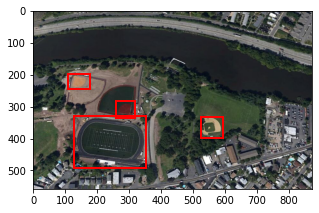

In [10]:
# plotting the image with bboxes. Feel free to change the index
img, target = dataset_test[27]
plot_img_bbox(img, target)

In [11]:
with torch.no_grad():
    prediction = model([img.to(device)])[0]

In [12]:
# pick one image from the test set
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  17
real #boxes:  4


MODEL OUTPUT
[525.273   332.6707  589.69836 385.558  ]
[126.52829 333.3872  349.2024  483.13452]
[420.96054   27.54365  640.40186  113.612236]
[199.33374 229.45459 334.42502 336.548  ]
[101.45418 199.43446 233.75041 305.09235]
[201.52864 233.01863 324.62094 340.43918]
[144.20796 344.57797 345.88953 475.01474]
[199.17392 236.29375 325.2471  339.66147]
[415.63986    6.484864 633.49457  124.927826]
[166.39487 344.21768 338.81174 471.0394 ]
[331.4229      3.3807087 672.22845   131.8996   ]
[478.67474   18.340517 555.572    123.4569  ]
[529.2121   33.57902 619.59424 124.20227]
[214.21239 241.78337 320.74368 326.80508]
[166.80531 357.10043 316.0742  464.4185 ]
[501.2191    20.463268 588.69635  123.63476 ]
[426.52097   14.280728 642.16046  120.30527 ]


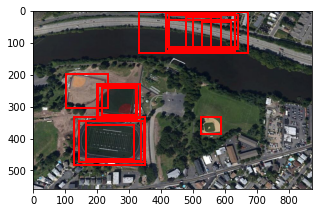

In [13]:
#1
print('MODEL OUTPUT')
from copy import deepcopy
pred = deepcopy(prediction)
pred['boxes']= pred['boxes'].cpu().numpy()
plot_img_bbox(img, pred)

In [14]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)

NMS APPLIED MODEL OUTPUT
[525.273   332.6707  589.69836 385.558  ]
[126.52829 333.3872  349.2024  483.13452]
[420.96054   27.54365  640.40186  113.612236]
[199.33374 229.45459 334.42502 336.548  ]
[101.45418 199.43446 233.75041 305.09235]


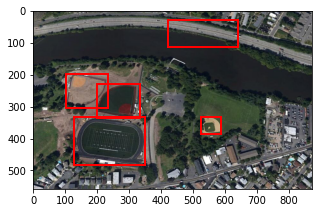

In [15]:
print('NMS APPLIED MODEL OUTPUT')
nms_prediction['boxes']= nms_prediction['boxes'].cpu().numpy()
plot_img_bbox(img, nms_prediction)